In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import torch.nn.functional as F

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from model import Model
from train import pretrain, eval_pretrain, train_supervised, eval_supervised
from tasks import deepcluster
from tsne import draw_tsne

import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = torchvision.datasets.FashionMNIST('.', train=True, transform=transform, download=True)
test_mnist = torchvision.datasets.FashionMNIST('.', train=False, transform=transform, download=True)

In [4]:
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=64, shuffle=False)

In [5]:
len(train_mnist), len(test_mnist)

(60000, 10000)

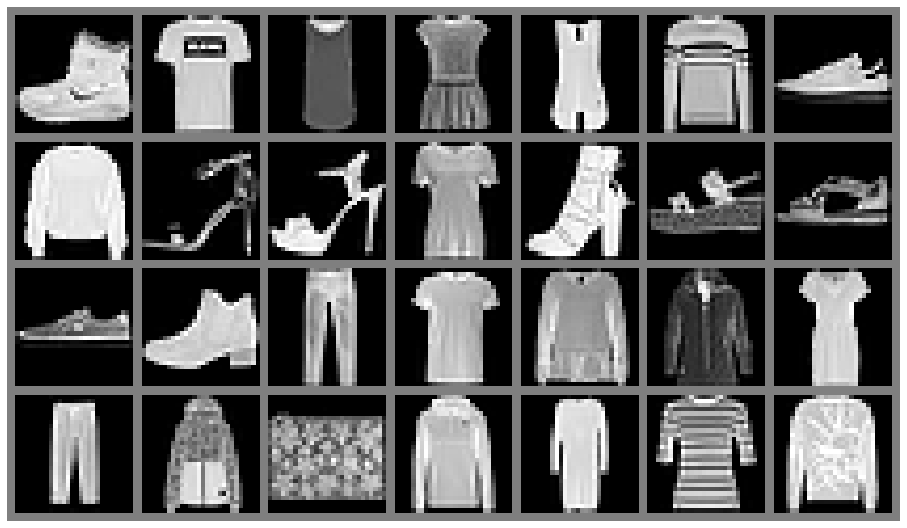

In [9]:
plt.figure(figsize=(16, 12))

image_list = [train_mnist[i][0] for i in range(4 * 7)]
grid = (torchvision.utils.make_grid(image_list, nrow=7) + 1) / 2

plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [140]:
def plot_loss(train, test, name=''):
    plt.figure(figsize=(6, 4))

    plt.plot(train, label='train', linewidth=3, alpha=1)
    plt.plot(test, label='test', linewidth=3, alpha=1)
    plt.legend(fontsize=16)
    plt.grid()
    plt.title(name, size=20)
    plt.xlabel('Step', size=18)
    plt.ylabel('Loss', size=18)
    plt.show()

## Random

In [315]:
model = Model().to(device)

In [316]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
puzzles: train_acc 0.13109375, test_acc 0.1479


  0%|          | 0/40 [00:00<?, ?it/s]

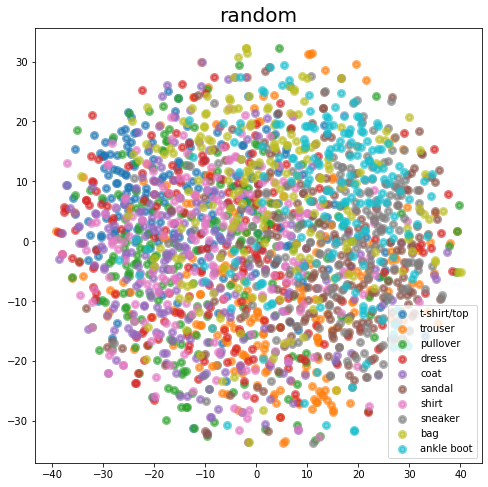

In [81]:
draw_tsne(model, test_mnist, name='random')

## Supervised

In [186]:
task = 'supervised'

In [187]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_loss, test_loss = [], []
for i in range(2):
    train_losses, train_acc = train_supervised(model, optimizer, train_mnist)
    test_losses, test_acc = eval_supervised(model, test_loader)

    train_loss.append(np.mean(train_losses))
    test_loss.append(np.mean(test_losses))

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

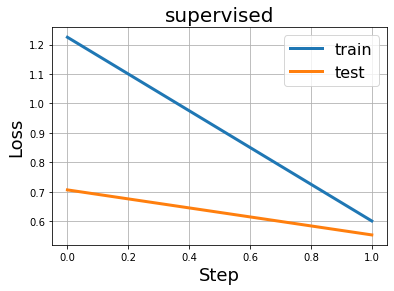

In [188]:
plot_loss(train_loss, test_loss, name=task)

In [124]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=5000)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

LINEAR PROBE
supervised: train_acc 0.799290625, test_acc 0.8166


  0%|          | 0/40 [00:00<?, ?it/s]

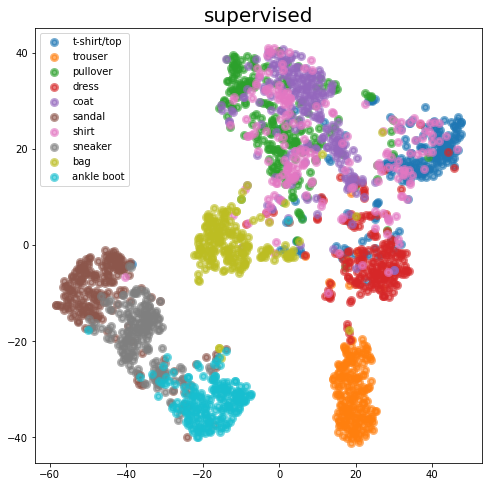

In [130]:
draw_tsne(model, test_mnist, name=task)

## Puzzles

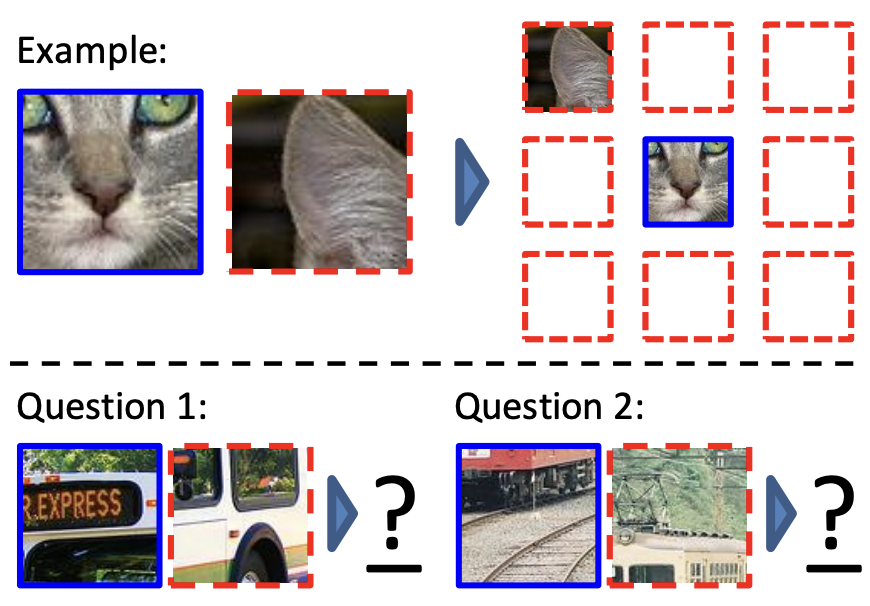

In [309]:
task = 'puzzles'

In [310]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss, test_loss = [], []
for i in range(4):
    train_losses, train_acc = pretrain(model, optimizer, train_loader, [task])
    test_losses, test_acc = eval_pretrain(model, test_loader, [task])

    train_loss.append(np.mean(train_losses))
    test_loss.append(np.mean(test_losses))

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

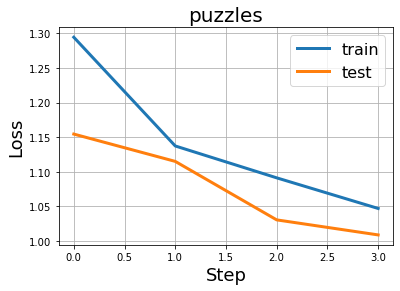

In [311]:
plot_loss(train_loss, test_loss, name=task)

In [314]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
puzzles: train_acc 0.2971875, test_acc 0.4265


  0%|          | 0/40 [00:00<?, ?it/s]

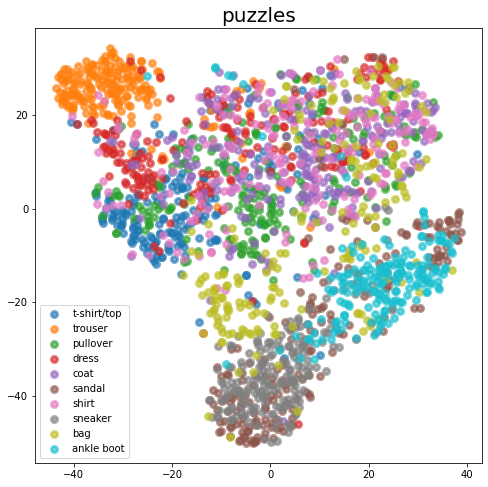

In [313]:
draw_tsne(model, test_mnist, name=task)

## Rotations

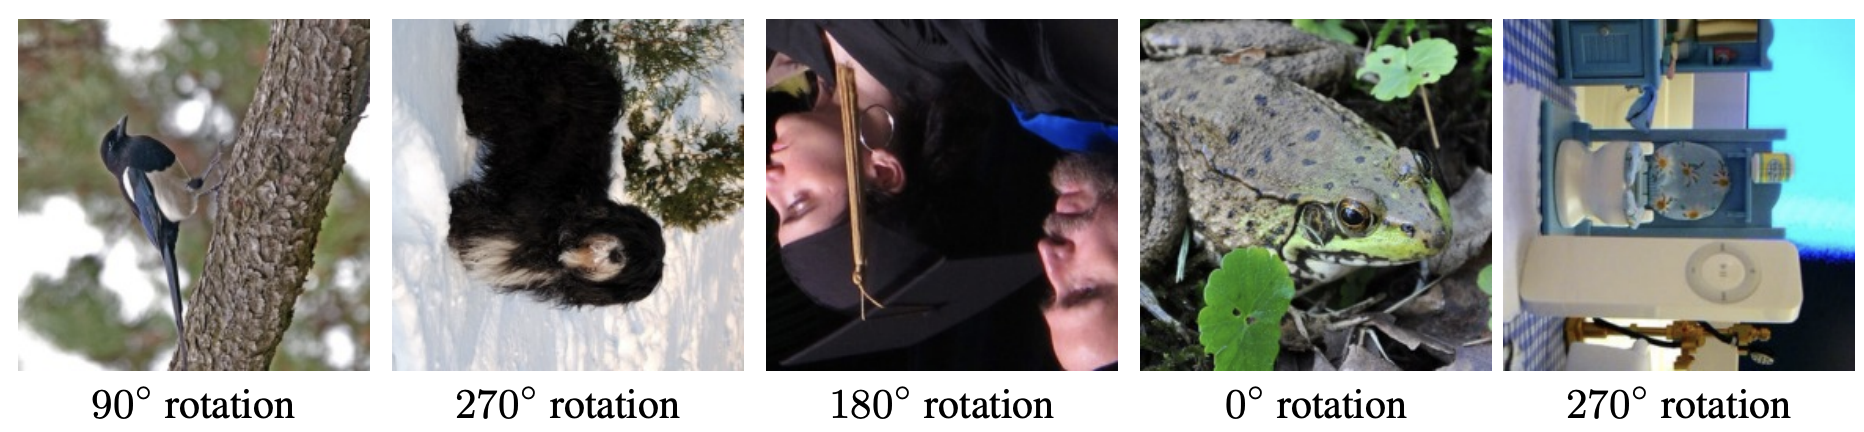

In [317]:
task = 'rotations'

In [307]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss, test_loss = [], []
for i in range(4):
    train_losses, train_acc = pretrain(model, optimizer, train_loader, [task])
    test_losses, test_acc = eval_pretrain(model, test_loader, [task])

    train_loss.append(np.mean(train_losses))
    test_loss.append(np.mean(test_losses))

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

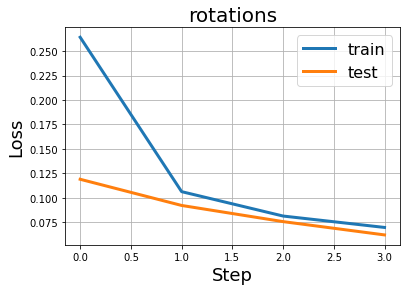

In [304]:
plot_loss(train_loss, test_loss, name=task)

In [319]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
rotations: train_acc 0.1775, test_acc 0.2571


  0%|          | 0/40 [00:00<?, ?it/s]

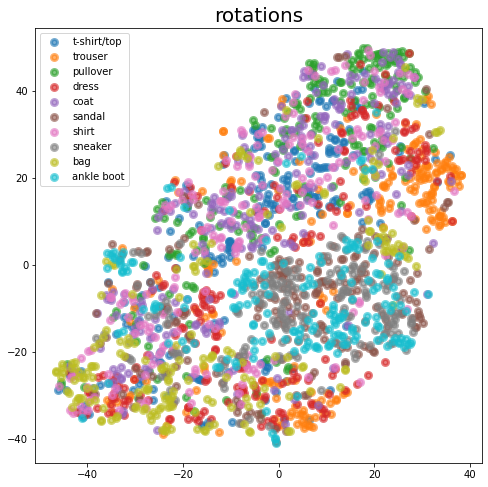

In [306]:
draw_tsne(model, test_mnist, name=task)

## Inpaining

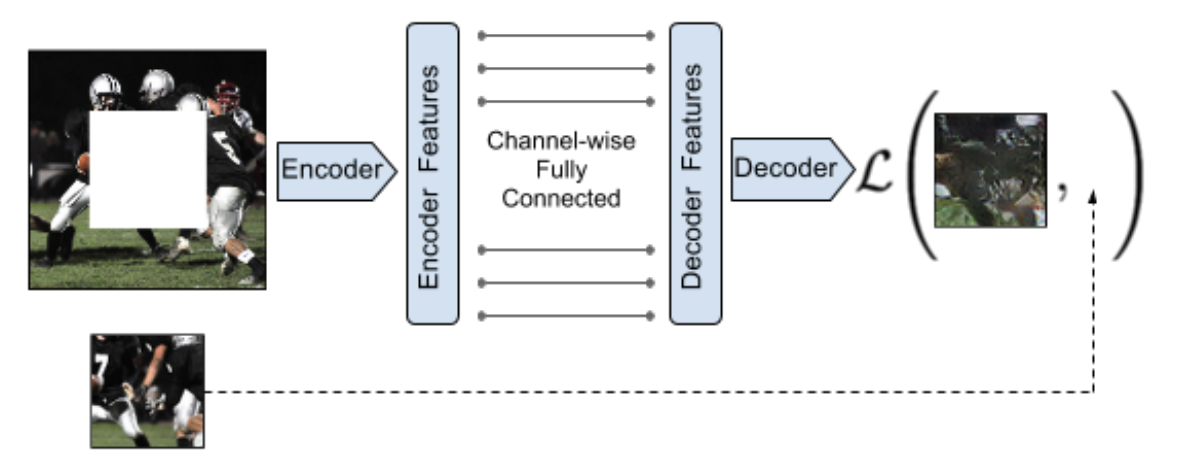

### Center

In [320]:
task = 'inpainting_center'

In [265]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss, test_loss = [], []
for i in range(4):
    train_losses, train_acc = pretrain(model, optimizer, train_loader, [task])
    test_losses, test_acc = eval_pretrain(model, test_loader, [task])

    train_loss.append(np.mean(train_losses))
    test_loss.append(np.mean(test_losses))

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

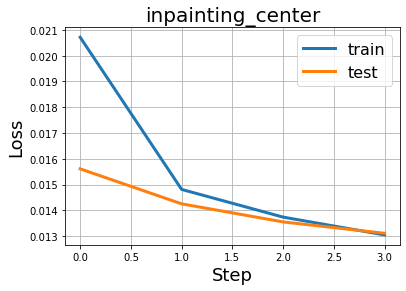

In [266]:
plot_loss(train_loss, test_loss, name=task)

In [322]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
inpainting_center: train_acc 0.2171875, test_acc 0.3495


  0%|          | 0/40 [00:00<?, ?it/s]

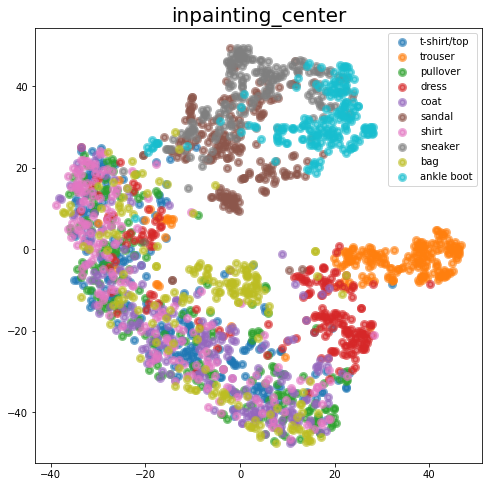

In [269]:
draw_tsne(model, test_mnist, name=task)

### Blocks

In [323]:
task = 'inpainting_blocks'

In [271]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss, test_loss = [], []
for i in range(4):
    train_losses, train_acc = pretrain(model, optimizer, train_loader, [task])
    test_losses, test_acc = eval_pretrain(model, test_loader, [task])

    train_loss.append(np.mean(train_losses))
    test_loss.append(np.mean(test_losses))

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

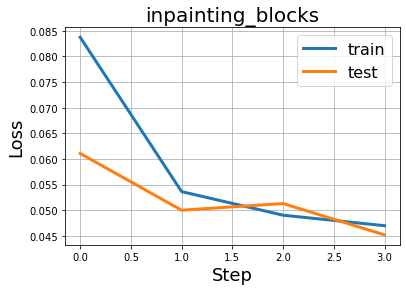

In [272]:
plot_loss(train_loss, test_loss, name=task)

In [324]:
model = Model().to(device)
model.load_state_dict(torch.load(f'models/{task}.pt'))

<All keys matched successfully>

In [325]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
inpainting_blocks: train_acc 0.35578125, test_acc 0.5946


  0%|          | 0/40 [00:00<?, ?it/s]

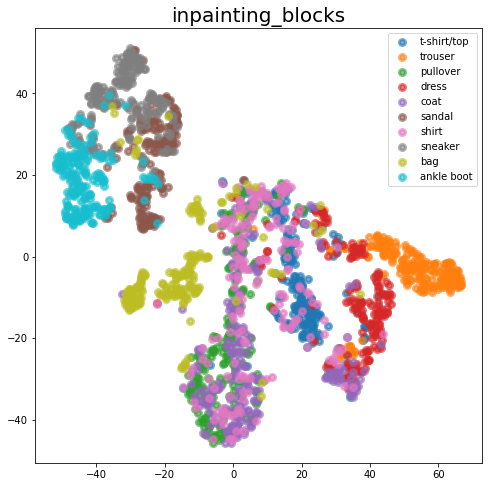

In [275]:
draw_tsne(model, test_mnist, name=task)

## DeepCluster

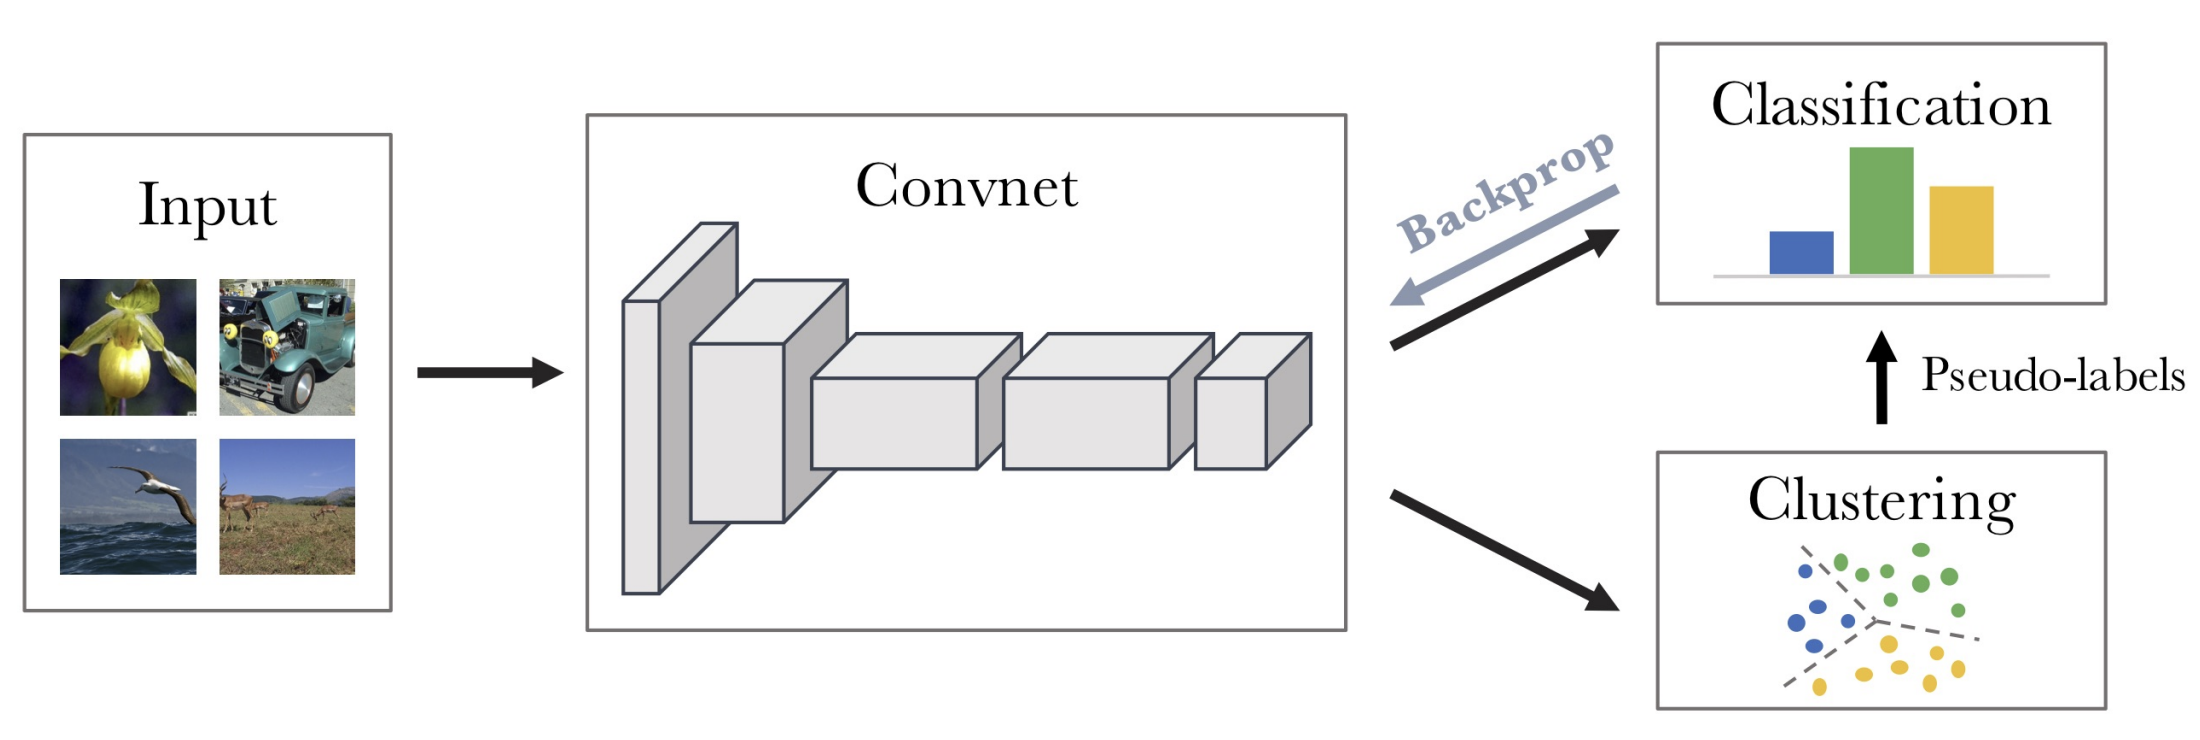

In [326]:
task = 'DeepCluster'

In [327]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

dataset = copy.copy(train_mnist)
accs = []
for i in range(3):
    acc = deepcluster(model, optimizer, dataset)
    accs.append(acc)

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/235 [00:00<?, ?it/s]

used 48 iterations (2.1503s) to cluster 60000 items into 100 clusters


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

used 100 iterations (2.7597s) to cluster 60000 items into 100 clusters


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

used 100 iterations (3.2175s) to cluster 60000 items into 100 clusters


  0%|          | 0/235 [00:00<?, ?it/s]

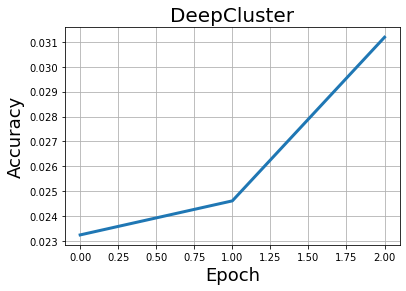

In [285]:
plt.plot(accs, linewidth=3)
plt.title(task, size=20)
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.grid()
plt.show()

In [328]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
DeepCluster: train_acc 0.279375, test_acc 0.4531


  0%|          | 0/40 [00:00<?, ?it/s]

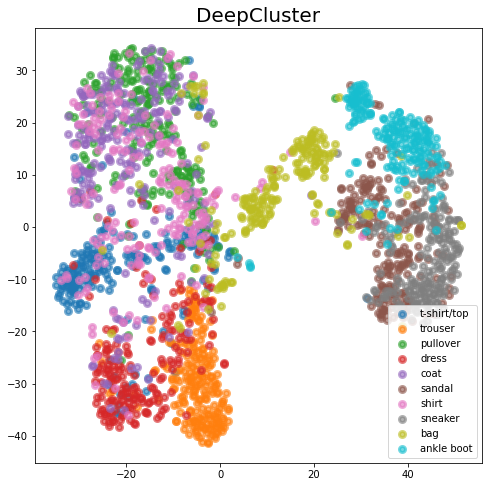

In [287]:
draw_tsne(model, test_mnist, name=task)

## Ensemble

In [340]:
tasks = ['puzzles', 'inpainting_blocks']
task = 'ensemble'

In [341]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss, test_loss = [], []
for i in range(3):
    train_losses, train_acc = pretrain(model, optimizer, train_loader, tasks)
    test_losses, test_acc = eval_pretrain(model, test_loader, tasks)

    train_loss.append(np.mean(train_losses))
    test_loss.append(np.mean(test_losses))

torch.save(model.state_dict(), f'models/{task}.pt')

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

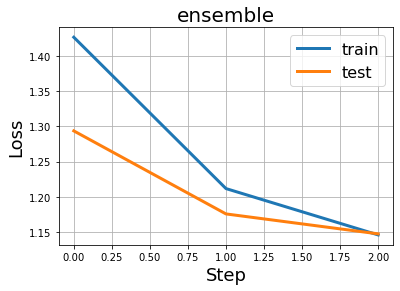

In [342]:
plot_loss(train_loss, test_loss, name=task)

In [343]:
train_repr_dataset = ReprDataset(model, train_mnist)
test_repr_dataset = ReprDataset(model, test_mnist)

train_acc, test_acc = run_linear_probe(train_repr_dataset, test_repr_dataset, n_iters=100)

print('LINEAR PROBE')
print(f'{task}: train_acc {train_acc}, test_acc {test_acc}')

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

LINEAR PROBE
ensemble: train_acc 0.3146875, test_acc 0.523


  0%|          | 0/40 [00:00<?, ?it/s]

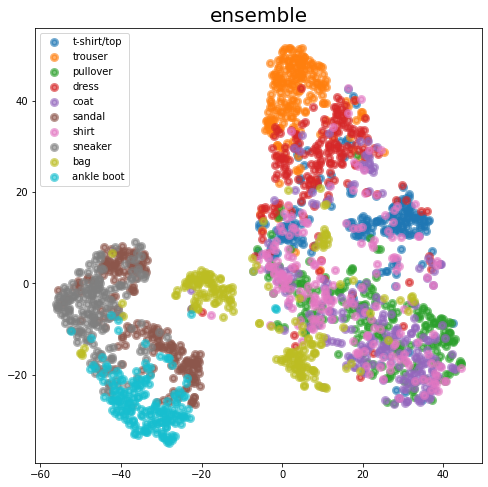

In [296]:
draw_tsne(model, test_mnist, name=task)